<a href="https://colab.research.google.com/github/CP2J/cp2j/blob/ACJ-11-opt1-RecSys_by_DL/RecSys_with_DL(occupation).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 딥러닝을 사용한 추천 시스템 - 변수추가
* User, Item을 embedding해서 입력으로 넣으면 사용자와 아이템 간의 특성을 학습해서 추천(예측)에 이용할 수 있다.
* 딥러닝 신경망은 필요하면 다양한 변수(사용자와 아이템의 features)를 추가할 수 있다.
* 사용자의 직업에 따라 영화를 평가하는 패턴이 다르다는 가정을 한다면, 직업을 모델에서 고려하는 경우 예측이 더 정확해질 것이다.

    < Reference : Python을 이용한 개인화 추천 시스템 2판 >

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
import pandas as pd
import numpy as np

# csv 파일에서 불러오기
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('/content/drive/MyDrive/ml-100k/u.data', names=r_cols,  sep='\t',encoding='latin-1')
ratings = ratings[['user_id', 'movie_id', 'rating']].astype(int)            # timestamp 제거, 정수형 변환

In [14]:
# Train-test 분리 (이렇게 나누는 방법도 있군)
from sklearn.utils import shuffle
TRAIN_SIZE = 0.75                         # 0.75 : 0.25
ratings = shuffle(ratings)                # row를 섞는다.
cutoff = int(TRAIN_SIZE * len(ratings))   # 끊는 지점
ratings_train = ratings.iloc[:cutoff]
ratings_test = ratings.iloc[cutoff:]

In [15]:
# 수정된 부분 1 >>>>>>>>>>
# 사용자 데이터를 읽어와 id와 직업만 남긴다.
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('/content/drive/MyDrive/ml-100k/u.user', sep='|', names=u_cols, encoding='latin-1')
users = users[['user_id', 'occupation']]

In [16]:
# Convert occupation(string to integer)
occupation = {}
# occupation을 dict 형식으로 바꾸기 위해 초기화
def convert_occ(x):
# occupation : string -> int
    if x in occupation:
        return occupation[x]
    # 만일 현재 occupation에 대응하는 int값이 dict 에 존재하면, 해당 값을 반환
    else:
    # 만일 현재 occupation에 대응하는 int값이 dict 에 존재하지 않으면,
        occupation[x] = len(occupation)
        # 새로운 element를 새로운 int와 같이 dict 에 추가한다.
        return occupation[x]
        # 새로운 int 값을 반환한다.
users['occupation'] = users['occupation'].apply(convert_occ)
# 사용자 데이터의 'occupation' 컬럼을 int로 변환

L = len(occupation)
# occupation의 unique 값 개수를 저장(추후 embedding에 사용)
train_occ = pd.merge(ratings_train, users, on = 'user_id')['occupation']
# train set과 사용자 데이터를 merge. 딥러닝의 입력으로 사용자의 occupation을 같이 사용하려면 모든 user_id에 대해 occupation 필요하다. 
test_occ = pd.merge(ratings_test, users, on = 'user_id')['occupation']
# test도 동일
#<<<<<<<<< 수정된 부분 1

In [17]:
occupation           # 20개의 직업을 int에 대응시킨 dict

{'technician': 0,
 'other': 1,
 'writer': 2,
 'executive': 3,
 'administrator': 4,
 'student': 5,
 'lawyer': 6,
 'educator': 7,
 'scientist': 8,
 'entertainment': 9,
 'programmer': 10,
 'librarian': 11,
 'homemaker': 12,
 'artist': 13,
 'engineer': 14,
 'marketing': 15,
 'none': 16,
 'healthcare': 17,
 'retired': 18,
 'salesman': 19,
 'doctor': 20}

In [18]:
##### (1)

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adamax

In [19]:
ratings.describe()

,user_id,movie_id,rating
count,100000.00000,100000.000000,100000.000000
mean,462.48475,425.530130,3.529860
std,266.61442,330.798356,1.125674
min,1.00000,1.000000,1.000000
25%,254.00000,175.000000,3.000000
50%,447.00000,322.000000,4.000000
75%,682.00000,631.000000,4.000000
max,943.00000,1682.000000,5.000000


In [20]:
# Variable 초기화
K = 200                               # Latent factor(잠재요인) 수
mu = ratings_train.rating.mean()      # 전체 평균
M = ratings.user_id.max() +1          # 사용자 아이디 최대값+1 : Number of users로 간주, 추후 Embedding에 사용
# 사용자 아이디는 1부터 943이지만(위 describe 참고)
# adding 1 ensures that all user IDs from 0 to the maximum ID are included in the embedding layer.
N = ratings.movie_id.max() +1         # Number of movies

# RMSE 정의
def RMSE(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

<img src="https://drive.google.com/uc?id=1sdPLEYtb9eJ50DwhAS-yDjlYRW7eHraf" alt="딥러닝 신경망 모델" height="300" width="400">

In [21]:
##### (2)
# Keras model
user = Input(shape=(1, ))                                             # 사용자 데이터 입력 형식 지정(id만 받음)
item = Input(shape=(1, ))                                             # 아이템 데이터 입력 형식 지정(id만 받음)
P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)      # 사용자 Embedding layer 지정 (M, 1, K) : (M X K)의 연결을 가진다.
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)      # 아이템 Embedding layer 지정 (N, 1, K) : (N X K)의 연결을 가진다.
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)        # User bias term (M, 1, ) : (M X 1)의 연결
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)        # Item bias term (N, 1, ) : (N X 1)의 연결

# Concatenate layers
from tensorflow.keras.layers import Dense, Concatenate, Activation    # 나중에 layer 구성에서 사용할 메소드 로드
P_embedding = Flatten()(P_embedding)          # (K, )
Q_embedding = Flatten()(Q_embedding)          # (K, )
user_bias = Flatten()(user_bias)              # (1, )
item_bias = Flatten()(item_bias)              # (1, )
# Concatenate() 위해서 1차원으로 줄인다.

# 수정된 부분 2 >>>>>>>>>>
occ = Input(shape=(1, ))                                                          # occupation에 대한 입력을 새로 만든다.
occ_embedding = Embedding(L, 3, embeddings_regularizer=l2())(occ)                 # occupation을 3개의 잠재요인으로 embedding한다. (K=3)
occ_layer = Flatten()(occ_embedding)                                              # 합치기 위해 차원 줄이기
R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias, occ_layer])    # (2K+2+3, )
# P, Q, 사용자 bias, 아이템 bias, occupation까지 붙여서 하나의 layer를 만든다.
#<<<<<<<<< 수정된 부분 2

# Neural network
R = Dense(2048)(R)              # 노드가 2048개인 dense layer 추가
R = Activation('relu')(R)       # 이 layer의 activation 함수 : 'relu'
R = Dense(256)(R)               # 노드가 256개인 dense layer 하나 더 추가
R = Activation('linear')(R)     # 이 layer의 activation 함수 : 'linear'
R = Dense(1)(R)                 # 노드가 1개인 dense layer를 하나 더 추가 한다. 이 layer가 출력에 연결된다.

# 수정된 부분 3 >>>>>>>>>>
# Model setting : 위의 신경망과 입력을 연결해서 모델을 구성한다.
model = Model(inputs = [user, item, occ], outputs = R)
#<<<<<<<<< 수정된 부분 3
model.compile(
    loss = RMSE,                # loss함수
    optimizer = SGD(),
    #optimizer = Adamax(),
    metrics = [RMSE]            # 측정지표
)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 1, 200)       188800      ['input_4[0][0]']                
                                                                                            

* input layer 2개가 각각 embedding layer에 연결된다.
* 사용자 수를 944(943+1)로 잡았기 때문에 200개의 잠재요인 layer(embedding)에 연결되는 파라미터의 수는 188,800(944 x 200)이 되고,
* 아이템의 수는 1683(1682+1)개 이므로 200개의 잠재요인 layer(embedding_1)에 연결되는 파라미터의 수는 336,600(1683 x 200)이 된다.
* 사용자 bias layer(embedding_2)는 944개, 아이템 bias layer(embedding_3)는 1683개의 파라미터를 갖는다.


Occupation은 20개이고, 3개의 잠재요인 layer(embedding_4)에 연결되는 파라미터의 수는 63(20*3 + 3)개이다.


* 이 5개의 embedding layer는 합쳐져서 하나의 layer(Concatenate)가 되고, 이 layer의 노드 수는 405개
(사용자 임베딩 200 + 아이템 임베딩 200 + 사용자 bias 1 + 아이템 bias 1 + 직업 임베딩 3)
* 다음으로 2048개의 노드를 갖는 Dense layer(dense)에 연결 : 이때 연결 파라미터 수는 831488((405+1) x 2048)개가 된다.
* 다음으로 256개의 노드를 갖는 Dense layer(dense_1)에 연결 : 이때 연결 파라미터 수는 524544((2048+1) x 256)개가 된다.
* 위 layer는 노드가 1개인 최종 layer(dense_2)에 연결되고 파라미터의 수는 257개가 된다.


총 파라미터의 수는 이들을 모두 합한 **1,884,379개**가 된다.

In [22]:
# Model fitting (위에서 구성한 신경망을 학습시킨다)
result = model.fit(
    x = [ratings_train.user_id.values, ratings_train.movie_id.values, train_occ.values],
    # 입력(독립변수)은 train set의 사용자, 아이템 id, occupation id
    y = ratings_train.rating.values - mu,
    # 출력(종속변수)은 평점에서 전체평균을 뺀 것으로 지정
    epochs = 65,              # 반복횟수
    batch_size = 512,         # 한번에 학습(연산)하는 batch 크기를 지정
    validation_data = (
      [ratings_test.user_id.values, ratings_test.movie_id.values, test_occ.values],  # 검증을 위한 입력
      ratings_test.rating.values - mu                               # 검증에 쓰이는 출력
    )
)

Epoch 1/65
147/147 [==============================] - 7s 11ms/step - loss: 5.3990 - RMSE: 1.1247 - val_loss: 5.2717 - val_RMSE: 1.1229
Epoch 2/65
147/147 [==============================] - 1s 6ms/step - loss: 5.1540 - RMSE: 1.1236 - val_loss: 5.0339 - val_RMSE: 1.1220
Epoch 3/65
147/147 [==============================] - 1s 5ms/step - loss: 4.9228 - RMSE: 1.1228 - val_loss: 4.8097 - val_RMSE: 1.1212
Epoch 4/65
147/147 [==============================] - 1s 5ms/step - loss: 4.7051 - RMSE: 1.1219 - val_loss: 4.5983 - val_RMSE: 1.1204
Epoch 5/65
147/147 [==============================] - 1s 6ms/step - loss: 4.4996 - RMSE: 1.1211 - val_loss: 4.3989 - val_RMSE: 1.1195
Epoch 6/65
147/147 [==============================] - 1s 6ms/step - loss: 4.3058 - RMSE: 1.1197 - val_loss: 4.2108 - val_RMSE: 1.1186
Epoch 7/65
147/147 [==============================] - 1s 5ms/step - loss: 4.1230 - RMSE: 1.1190 - val_loss: 4.0334 - val_RMSE: 1.1176
Epoch 8/65
147/147 [==============================] - 1s 5ms/

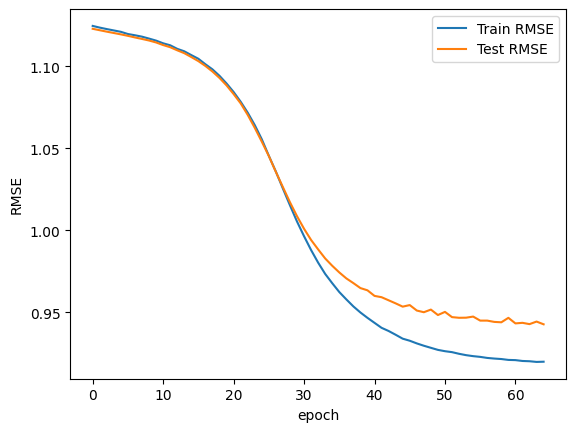

In [23]:
# 학습과정에서 측정지표의 변화
import matplotlib.pyplot as plt
plt.plot(result.history['RMSE'], label="Train RMSE")
plt.plot(result.history['val_RMSE'], label="Test RMSE")
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [26]:
# Prediction (학습을 마친 신경망으로 예측을 수행)
user_ids = ratings_test.user_id.values[0:6]
movie_ids= ratings_test.movie_id.values[0:6]                          # 예측 대상을 테스트셋 처음 6개로 정함
user_occ = test_occ[0:6]
predictions = model.predict([user_ids, movie_ids, user_occ]) + mu     # 예측치를 구한 후 학습시 빼준 전체평균을 다시 더해줌
print("Actuals: \n", ratings_test[0:6])
print( )
print("Predictions: \n", predictions)

1/1 [==============================] - 0s 123ms/step
Actuals: 
        user_id  movie_id  rating
92856      896       307       3
77655      291        97       4
33913      297       919       1
5453       343        44       3
16962      178       323       3
52308      592       259       2

Predictions: 
 [[2.9178283]
 [4.103764 ]
 [3.5514154]
 [3.7080657]
 [2.987524 ]
 [2.9397125]]


In [27]:
# 신경망에서 예측한 결과의 실제 RMSE 계산
def RMSE2(y_true, y_pred):
    return np.sqrt( np.mean( ( np.array(y_true) - np.array(y_pred) )**2 ) )

user_ids = ratings_test.user_id.values
movie_ids = ratings_test.movie_id.values

y_pred = model.predict([user_ids, movie_ids, test_occ]) + mu
# Keras의 Model 클래스에서 제공하는 predict() 메소드는 신경망에 입력을 넣어주면 해당 신경망을 적용한 예측값을 계산해준다.
y_pred = np.ravel(y_pred, order = 'C')
# predict()로 얻은 예측값은 2차원(N X 1)의 array로 되어있으므로 np.ravel을 사용, 1차원 array로 바꿔준다.
y_true = np.array(ratings_test.rating)
# 실제 평점값을 가져온다.
RMSE2(y_true, y_pred)

782/782 [==============================] - 1s 2ms/step


0.9433401348661025